In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.special as poly
from math import factorial

In [2]:
dof = 4
numsteps = 25000
savesteps = 10
ft = 10.0
ic = np.array([1.0])
it = np.array([0.0])
dt = ft / savesteps

g = 1/2
coef = np.array([1., 2., -1., -0.5])

In [3]:
def mypoly(x):
    y = np.zeros((x.size, dof))
    for i in range(x.size):
        for j in range(dof):
            H = poly.hermitenorm(j, monic = True)
            # normalization constant = np.sqrt(np.sqrt(2 * np.pi) * factorial(j))
            # for probabilist's Hermite (hermitenorm)
            # normalization constant = np.sqrt(np.sqrt(np.pi) * (2**j) * factorial(j))
            # for physicists' Hermite (hermite)
            y[i,j] = H(x[i]) / np.sqrt(np.sqrt(2 * np.pi) * factorial(j))
    return y

In [4]:
def drift(x, theta):
    return (np.dot(mypoly(x), theta))

In [5]:
j = 1
x = np.zeros(savesteps + 1)
t = np.zeros(savesteps + 1)
h = ft / numsteps
h12 = np.sqrt(h)
x[0] = ic
t[0] = it

for i in range(1, numsteps + 1):
    ic = ic + drift(ic, coef) * h + g * h12 * np.random.standard_normal(1)
    if (i % (numsteps / savesteps) == 0):
        x[j] = ic
        t[j] = i*h + it
        j = j + 1

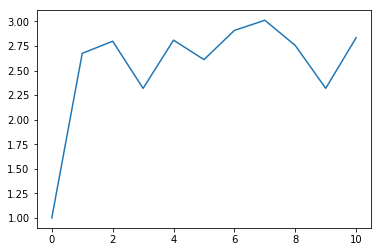

In [6]:
plt.plot(t, x)

In [7]:
def brownianbridge(g, xin, tin, n, index):
    h = (tin[index + 1] - tin[index]) / n
    tvec = tin[index] + (1+np.arange(n))*h
    h12 = np.sqrt(h)
    wincs = np.random.normal(scale=h12*g, size=n)
    w = np.cumsum(wincs)
    bridge = xin[index] + w - ((tvec - tin[index])/(tin[index + 1]-tin[index]))*(w[n-1] + xin[index] - xin[index + 1])
    tvec = np.concatenate((t[[index]], tvec))
    bridge = np.concatenate((x[[index]],bridge))
    return tvec, bridge

In [8]:
# girsanov LOG likelihood
def girsanov(g, path, dt, theta):
    b = drift(path, theta)
    int1 = np.dot(b[:-1]/(g*g), np.diff(path))
    b2 = np.square(b)/(g*g)
    int2 = np.sum(0.5*(b2[1:] + b2[:-1]))*dt
    r = int1 - 0.5*int2
    return r

In [9]:
theta = np.array([1.5, 1., 0., -0.25])
numsubintervals = 100
h = (t[1] - t[0])/numsubintervals
numpaths = 1000
burninpaths = 10

In [10]:
done = False
mytol = 1e-3
numiter = 0
while (done == False):
    numiter = numiter + 1
    print(numiter)
    mmat = np.zeros((dof, dof))
    rvec = np.zeros(dof)
    
    # for each interval of observed value (x_0 to x_n)
    for i in range(x.size-1):
        samples = np.zeros(numsubintervals)
        tout, xcur = brownianbridge(g,x,t,numsubintervals, i)
        oldlik = girsanov(g=g, path=xcur, dt=h, theta=theta)
        arburn = np.zeros(burninpaths)
        for jj in range(burninpaths):
            _, prop = brownianbridge(g,x,t,numsubintervals,i)
            proplik = girsanov(g=g, path=prop, dt=h, theta=theta)
            rho = np.exp(proplik - oldlik)
            if (rho > np.random.uniform()):
                xcur = prop
                oldlik = proplik
                arburn[jj] = 1
                
        print("Acceptance rate during burn-in:", np.mean(arburn))

        # for each path being sampled (r = 0 to r = R)
        arsamp = np.zeros(numpaths)
        for jj in range(numpaths):
            _, prop = brownianbridge(g,x,t,numsubintervals,i)
            proplik = girsanov(g=g, path=prop, dt=h, theta=theta)
            rho = np.exp(proplik - oldlik)
            if (rho > np.random.uniform()):
                xcur = prop
                oldlik = proplik
                arsamp[jj] = 1
            samples = xcur
            pp = mypoly(samples[:(-1)])
            mmat = mmat + h * np.matmul(pp.T, pp) / numpaths
            rvec = rvec + np.matmul((np.diff(samples)).T, pp) / numpaths    
        print("Acceptance rate post burn-in:", np.mean(arsamp))
    newtheta = np.linalg.solve(mmat, rvec)
    check = np.sum(np.abs(newtheta - theta))
    if (check < mytol):
        print("finished!")
        print(check)
        print(theta)
        done = True
    theta = newtheta
    print(check)
    print(theta)

1
Acceptance rate during burn-in: 0.9
Acceptance rate post burn-in: 0.858
Acceptance rate during burn-in: 0.4
Acceptance rate post burn-in: 0.544
Acceptance rate during burn-in: 0.9
Acceptance rate post burn-in: 0.586
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.629
Acceptance rate during burn-in: 0.6
Acceptance rate post burn-in: 0.504
Acceptance rate during burn-in: 0.5
Acceptance rate post burn-in: 0.558
Acceptance rate during burn-in: 0.7
Acceptance rate post burn-in: 0.505
Acceptance rate during burn-in: 0.6
Acceptance rate post burn-in: 0.536
Acceptance rate during burn-in: 0.9
Acceptance rate post burn-in: 0.683
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in: 0.581
25.7584102414
[ -6.83001656  10.59149804  -6.23804955   1.34884609]
2
Acceptance rate during burn-in: 0.8
Acceptance rate post burn-in: 0.628
Acceptance rate during burn-in: 0.8
Acceptance rate post burn-in: 0.851
Acceptance rate during burn-in: 1.0
Acceptance rate post burn-in

KeyboardInterrupt: 